# **UCSB ECE180 FINAL PROJECT - F25**
### Jay Udall
### Perm No: 3084761
### Date: 12/08/2025

In this project, we will be exploring different model architectures and variations to predict carbohydrate content from meal descriptions. We will be using the SentenceTransformers library (specifically the all-MiniLM-L6-v2 model) to encode the text into dense embeddings as features for our different regressors. There are three model architectures we will be exploring:

1. A Multi-Layer Perceptron (MLP) with 2 hidden layers
2. A vanilla Recurrent Neural Network (RNN) with hidden_dim of 64
3. A Long Short-Term Memory (LSTM) model before and after gradient clipping + dropout

For the purposes of this project, we will be sticking with 25 epochs as this is a pretty reliable range for this scale. Our initial expectation is that the RNN and LSTM models will outperform the MLP due to these models being able to capture sequence patterns; however, this is less of a sentiment analysis problem, so individual words and short sequence meanings in the meal descriptions might be captured adequately by the MLP. Let's find out.

In [21]:
# IMPORT NECESSARY LIBRARIES (we will be using PyTorch)

import re
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [22]:
# DEFINE HELPER FUNCTIONS FOR DATA PREPROCESSING AND ENCODING

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def pad_embedding_sequences(list_of_sequences):
    """
    list_of_sequences: list of tensors shape (T_i, D)
    returns padded: (batch, max_T, D)
    """
    return pad_sequence(list_of_sequences, batch_first=True)

# FUNCTION TO ENCODE TRAINING + VALIDATION DATA
def prepare_inputs(model_type, train_set, val_set, encoder):
    y_train = torch.tensor(train_set["carb"].values, dtype=torch.float32).to(device)
    y_val = torch.tensor(val_set["carb"].values, dtype=torch.float32).to(device)

    # preprocess specific to MLP
    if model_type == "mlp":

        train_vec = encoder.encode_sentence(train_set["query"].tolist())
        val_vec = encoder.encode_sentence(val_set["query"].tolist())

        train_X = torch.tensor(train_vec, dtype=torch.float32).to(device)
        val_X   = torch.tensor(val_vec, dtype=torch.float32).to(device)

        embed_dim = train_X.shape[1]
        return train_X, y_train, val_X, y_val, embed_dim

    # this is the preprocessing for RNN/LSTM
    train_sequences = encoder.encode_tokens(train_set["query"].tolist())
    val_sequences = encoder.encode_tokens(val_set["query"].tolist())

    train_X = pad_embedding_sequences(train_sequences).to(device)
    val_X = pad_embedding_sequences(val_sequences).to(device)

    embed_dim = train_sequences[0].shape[1]

    return train_X, y_train, val_X, y_val, embed_dim

# SEPARATE FUNCTION TO ENCODE TEST DATA
def prepare_test_inputs(model_type, test_set, encoder):
    if model_type == "mlp":
        # Sentence-level embeddings
        test_vec = encoder.encode_sentence(test_set["query"].tolist())
        X_test = torch.tensor(test_vec, dtype=torch.float32).to(device)
        embed_dim = X_test.shape[1]
        return X_test, embed_dim

    # token-level embeddings
    test_sequences = encoder.encode_tokens(test_set["query"].tolist())

    # token embedding dim
    embed_dim = test_sequences[0].shape[1]

    # pad all sequences to same length
    X_test = pad_embedding_sequences(test_sequences).to(device)

    return X_test, embed_dim


In [23]:
## CLASS DEFINITIONS (ENCODER + MODELS: MLP, RNN, LSTM)

class Encoder:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.embedder = SentenceTransformer(model_name, device=device)
        print(f"Loaded SentenceTransformer model: {model_name}")

    def encode_sentence(self, texts):
        texts = [clean_text(t) for t in texts]
        return self.embedder.encode(texts, convert_to_numpy=True)

    def encode_tokens(self, texts):
        texts = [clean_text(t) for t in texts]
        return self.embedder.encode(texts,
                                    output_value="token_embeddings",
                                    convert_to_tensor=True)

# first variation - simple MLP with 2 hidden layers and hidden_dim=256
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()

        # define first fully connected and activation layers
        # Layer 1: input_dim → hidden_dim
        self.W1 = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(hidden_dim))

        # Layer 2: hidden_dim → hidden_dim/2
        self.W2 = nn.Parameter(torch.randn(hidden_dim, hidden_dim // 2) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(hidden_dim // 2))

        # Output layer: hidden_dim/2 → 1
        self.W3 = nn.Parameter(torch.randn(hidden_dim // 2, 1) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(1))

        # Activation function
        self.relu = lambda x: torch.clamp(x, min=0.0)

    def forward(self, x):
        # Layer 1
        h1 = x @ self.W1 + self.b1
        h1 = self.relu(h1)

        # Layer 2
        h2 = h1 @ self.W2 + self.b2
        h2 = self.relu(h2)

        # Output layer
        out = h2 @ self.W3 + self.b3
        return out.squeeze(-1)

# second variation - RNN
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Learnable weights
        self.Wxh = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.Whh = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.bh  = nn.Parameter(torch.zeros(hidden_dim))

        # Output layer weights
        self.Who = nn.Parameter(torch.randn(hidden_dim, output_dim) * 0.1)
        self.bo  = nn.Parameter(torch.zeros(output_dim))

        self.tanh = torch.tanh
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):

        batch_size, seq_len, _ = x.shape

        # Initial hidden state
        h = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        # Loop over time steps manually
        for t in range(seq_len):
            x_t = x[:, t, :]  # (batch, input_dim)

            h = self.tanh(
                x_t @ self.Wxh +     # (batch, hidden_dim)
                h @ self.Whh +       # (batch, hidden_dim)
                self.bh              # (hidden_dim)
            )
            # added dropout to combat overfitting
            h = self.dropout(h)

        # Final output: y = h_T * Who + bo
        out = h @ self.Who + self.bo   # (batch, output_dim)

        return out.squeeze(-1)  # (batch,)

# third variation - LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim, optimized, hidden_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # learnable weights - each gate has Wx, Wh, and b
        self.W_xi = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hi = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_i  = nn.Parameter(torch.zeros(hidden_dim))

        self.W_xf = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hf = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_f  = nn.Parameter(torch.zeros(hidden_dim))

        self.W_xg = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hg = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_g  = nn.Parameter(torch.zeros(hidden_dim))

        self.W_xo = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_ho = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_o  = nn.Parameter(torch.zeros(hidden_dim))

        self.W_hy = nn.Parameter(torch.randn(hidden_dim, 1) * 0.1)
        self.b_y  = nn.Parameter(torch.zeros(1))

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)
        self.optimized = optimized

        # initialize orthogonal recurrent weights and add 1 to forget bias
        self.reset_parameters()

    def reset_parameters(self):
        # Input weights
        nn.init.xavier_uniform_(self.W_xi)
        nn.init.xavier_uniform_(self.W_xf)
        nn.init.xavier_uniform_(self.W_xg)
        nn.init.xavier_uniform_(self.W_xo)

        # Recurrent weights
        nn.init.orthogonal_(self.W_hi)
        nn.init.orthogonal_(self.W_hf)
        nn.init.orthogonal_(self.W_hg)
        nn.init.orthogonal_(self.W_ho)

        # Forget gate bias = +1
        with torch.no_grad():
            self.b_f.fill_(1.0)

        # Output weights
        nn.init.xavier_uniform_(self.W_hy)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        for t in range(seq_len):

            x_t = x[:, t, :]

            W_x = torch.cat([self.W_xi, self.W_xf, self.W_xg, self.W_xo], dim=1)
            W_h = torch.cat([self.W_hi, self.W_hf, self.W_hg, self.W_ho], dim=1)
            b   = torch.cat([self.b_i,  self.b_f,  self.b_g,  self.b_o], dim=0)

            z = x_t @ W_x + h_t @ W_h + b   # (batch, 4*hidden_dim)

            i_t, f_t, g_t, o_t = torch.split(z, self.hidden_dim, dim=1)

            i_t = torch.sigmoid(i_t)   # input gate
            f_t = torch.sigmoid(f_t)   # forget gate
            g_t = torch.tanh(g_t)      # candidate memory
            o_t = torch.sigmoid(o_t)   # output gate

            # cell state update
            c_t = f_t * c_t + i_t * g_t

            # update hidden state
            h_t = o_t * self.tanh(c_t)

            # only use dropout if we are using the optimized version
            if self.optimized:
              h_t = self.dropout(h_t)

        y = h_t @ self.W_hy + self.b_y   # (batch, 1)
        return y.squeeze(1)


In [24]:
def initialize_model(model_type, input_dim, optimized=True):
    if model_type=="mlp":
      model = MLP(input_dim).to(device)
    elif model_type=="rnn":
      model = RNN(input_dim).to(device)
    elif model_type=="lstm":
      model = LSTM(input_dim, optimized).to(device)
    else:
      raise ValueError("Only MLP, RNN, or LSTM supported.")

    return model

Next, we will define our training and metrics functions.

In [25]:
# DEFINE UNIVERSAL MODEL TRAINING FUNCTION
# we use a boolean "optimized" variable to test the effects of certain optimizations
def train(
    model,
    optimized,
    train_X, train_y,
    val_X, val_y,
    epochs=20,
    batch_size=32,
    lr=1e-3,

):

  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.MSELoss()
  n = train_X.size(0)
  history = {"train_loss": [], "val_loss": []}

  for epoch in range(epochs):
    model.train()
    perm = torch.randperm(n)
    epoch_loss = 0
    for i in range(0, n, batch_size):
      idx = perm[i:i + batch_size]
      X_batch = train_X[idx]
      y_batch = train_y[idx]

      optimizer.zero_grad()

      # X_batch = MLP ? (batch, embed_dim) : (batch, seq_len, embed_dim)
      preds = model(X_batch)

      loss = loss_fn(preds, y_batch)
      loss.backward()

      if optimized:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
      val_losses = []
      for i in range(0, val_X.size(0), batch_size):
        Xb = val_X[i:i+batch_size]
        yb = val_y[i:i+batch_size]
        if Xb.size(0) != batch_size:
          continue
        preds = model(Xb)
        val_losses.append(loss_fn(preds, yb).item())

      val_loss = sum(val_losses) / len(val_losses)

    avg_train = epoch_loss / (n // batch_size)

    history["train_loss"].append(avg_train)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} "
          f"Train Loss: {avg_train:.4f} | Val Loss: {val_loss:.4f}")

  return history

def compute_val_metrics(model):
  batch_size = 32
  model.eval()
  val_preds = []
  with torch.no_grad():
      for i in range(0, X_val.size(0), batch_size):
          Xb = X_val[i:i+batch_size]
          preds = model(Xb)
          val_preds.append(preds.cpu())
  val_preds = torch.cat(val_preds)

  mse  = nn.MSELoss()(val_preds, y_val.cpu()).item()
  rmse = mse ** 0.5
  mae  = torch.mean(torch.abs(val_preds - y_val.cpu())).item()

  print("Val MSE:", mse)
  print("Val RMSE:", rmse)
  print("Val MAE:", mae)


In [26]:
# INITIALIZE ENCODER AND READ IN DATA
encoder=Encoder()
train_set = pd.read_csv('train.csv')
val_set = pd.read_csv('val.csv')
test_set = pd.read_csv('test.csv')

Loaded SentenceTransformer model: all-MiniLM-L6-v2


#MODEL 1 - MULTI-LAYER PERCEPTRON

In [29]:
# TRAIN AND EVALUATE USING MLP MODEL
X_train, y_train, X_val, y_val, embed_dim = prepare_inputs(
    "mlp",
    train_set,
    val_set,
    encoder
)

mlp_model = initialize_model("mlp", input_dim=embed_dim)

mlp_history = train(
    mlp_model,
    True,
    X_train, y_train,
    X_val, y_val,
    epochs=25,
    batch_size=32,
    lr=1e-3
)

print("\nEvaluating metrics for MLP model:")
compute_val_metrics(mlp_model)

Epoch 1/25 Train Loss: 1675.5253 | Val Loss: 1215.8234
Epoch 2/25 Train Loss: 1409.6896 | Val Loss: 1137.4180
Epoch 3/25 Train Loss: 1295.7622 | Val Loss: 1087.2995
Epoch 4/25 Train Loss: 1216.0200 | Val Loss: 1014.5291
Epoch 5/25 Train Loss: 1128.6777 | Val Loss: 1001.2809
Epoch 6/25 Train Loss: 1066.1290 | Val Loss: 931.7499
Epoch 7/25 Train Loss: 989.7134 | Val Loss: 911.7573
Epoch 8/25 Train Loss: 918.1420 | Val Loss: 865.6485
Epoch 9/25 Train Loss: 860.6061 | Val Loss: 850.8283
Epoch 10/25 Train Loss: 790.5517 | Val Loss: 814.3731
Epoch 11/25 Train Loss: 752.7425 | Val Loss: 785.6655
Epoch 12/25 Train Loss: 695.1327 | Val Loss: 742.7061
Epoch 13/25 Train Loss: 642.3245 | Val Loss: 713.3635
Epoch 14/25 Train Loss: 582.5035 | Val Loss: 688.1923
Epoch 15/25 Train Loss: 551.4011 | Val Loss: 704.6525
Epoch 16/25 Train Loss: 489.8063 | Val Loss: 697.0115
Epoch 17/25 Train Loss: 455.6508 | Val Loss: 636.7606
Epoch 18/25 Train Loss: 415.6862 | Val Loss: 630.9423
Epoch 19/25 Train Loss: 38

We can see from the above output that the MLP performs surprisingly well with low error metrics relative to the variation in carb content. This could confirm our initial idea that these carb content patterns aren't too reliant on long text sequences, but rather individual, smaller groups of words.

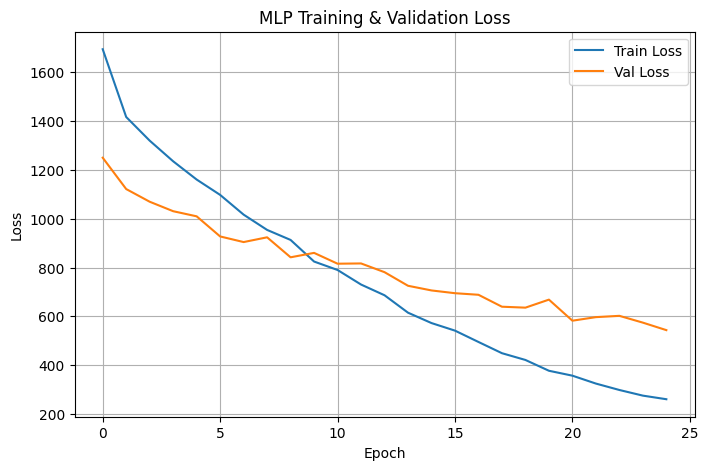

In [28]:
plt.figure(figsize=(8,5))

plt.plot(mlp_history["train_loss"], label="Train Loss")
plt.plot(mlp_history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

**ANALYSIS:**
From this plot we can see clear signs of overfitting from our MLP model because the training loss decreases much faster than our validation loss, and past around epoch 13 we aren't getting much better on unseen data while the model continues to improve on training data. This means that the model is going to perform much better on data it has seen before without being able to generalize efficiently.

#MODEL 2 - VANILLA RNN

In [30]:
# TRAIN AND EVALUATE USING RNN MODEL
X_train, y_train, X_val, y_val, embed_dim = prepare_inputs(
    "rnn",
    train_set,
    val_set,
    encoder
)

rnn_model = initialize_model("rnn", input_dim=embed_dim)

rnn_history = train(
    rnn_model,
    True,
    X_train, y_train,
    X_val, y_val,
    epochs=25,
    batch_size=32,
    lr=1e-3
)

print("\nEvaluating metrics for RNN model:")
compute_val_metrics(rnn_model)

Epoch 1/25 Train Loss: 1989.9722 | Val Loss: 1579.6077
Epoch 2/25 Train Loss: 1857.6560 | Val Loss: 1565.4745
Epoch 3/25 Train Loss: 1854.9469 | Val Loss: 1562.2582
Epoch 4/25 Train Loss: 1852.2407 | Val Loss: 1564.9341
Epoch 5/25 Train Loss: 1851.9917 | Val Loss: 1562.7826
Epoch 6/25 Train Loss: 1854.9624 | Val Loss: 1562.0747
Epoch 7/25 Train Loss: 1853.9588 | Val Loss: 1562.5836
Epoch 8/25 Train Loss: 1851.5129 | Val Loss: 1562.4210
Epoch 9/25 Train Loss: 1859.1863 | Val Loss: 1566.3071
Epoch 10/25 Train Loss: 1856.2206 | Val Loss: 1565.5257
Epoch 11/25 Train Loss: 1848.7830 | Val Loss: 1562.8660
Epoch 12/25 Train Loss: 1854.7687 | Val Loss: 1565.0628
Epoch 13/25 Train Loss: 1852.3419 | Val Loss: 1564.2018
Epoch 14/25 Train Loss: 1851.3814 | Val Loss: 1563.5326
Epoch 15/25 Train Loss: 1854.1799 | Val Loss: 1565.9782
Epoch 16/25 Train Loss: 1856.3349 | Val Loss: 1560.5164
Epoch 17/25 Train Loss: 1850.0550 | Val Loss: 1562.2019
Epoch 18/25 Train Loss: 1853.5825 | Val Loss: 1565.5127
E

The above metrics for the vanilla RNN are significantly worse than the first, and show that this model is pretty lousy compared to even the simple MLP. This is further confirmation that the long-term sequence capturing of the RNN is not needed in this case, although there could definitely be some modifications that would slightly improve the performance. If we were to look at improving our predictions, it would be wiser to start with the MLP model from earlier instead.

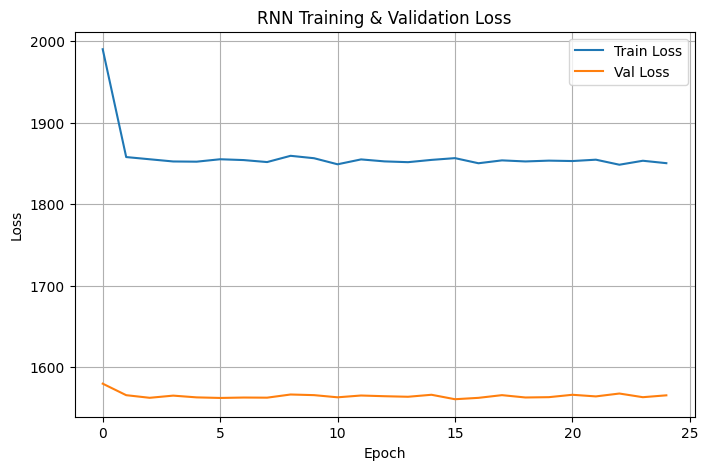

In [31]:
plt.figure(figsize=(8,5))

plt.plot(rnn_history["train_loss"], label="Train Loss")
plt.plot(rnn_history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

**ANALYSIS:** The plot above shows very subpar performance from the vanilla RNN. There is clear evidence of vanishing  gradients after the first epoch, which is why we saw little to no improvement from then on. This is a common issue with this type of model, especially when implemented from scratch in our case.

#MODEL 3 - NON-OPTIMIZED LSTM

In [32]:
# TRAIN AND EVALUATE USING LSTM MODEL - first without grad clipping or dropout
X_train, y_train, X_val, y_val, embed_dim = prepare_inputs(
    "lstm",
    train_set,
    val_set,
    encoder
)

lstm_model_1 = initialize_model("lstm", input_dim=embed_dim, optimized=False)

lstm1_history = train(
    lstm_model_1,
    False,
    X_train, y_train,
    X_val, y_val,
    epochs=25,
    batch_size=32,
    lr=1e-3
)
print("\nEvaluating metrics for first LSTM model:")
compute_val_metrics(lstm_model_1)


Epoch 1/25 Train Loss: 1823.7435 | Val Loss: 1361.5156
Epoch 2/25 Train Loss: 1584.1106 | Val Loss: 1237.5036
Epoch 3/25 Train Loss: 1458.6024 | Val Loss: 1140.7461
Epoch 4/25 Train Loss: 1377.6760 | Val Loss: 1069.0728
Epoch 5/25 Train Loss: 1282.1015 | Val Loss: 1022.3569
Epoch 6/25 Train Loss: 1186.9533 | Val Loss: 967.5033
Epoch 7/25 Train Loss: 1113.9048 | Val Loss: 979.7129
Epoch 8/25 Train Loss: 1038.7626 | Val Loss: 851.3269
Epoch 9/25 Train Loss: 959.9388 | Val Loss: 823.8065
Epoch 10/25 Train Loss: 914.5498 | Val Loss: 804.7378
Epoch 11/25 Train Loss: 904.0025 | Val Loss: 760.2015
Epoch 12/25 Train Loss: 882.0207 | Val Loss: 866.9606
Epoch 13/25 Train Loss: 819.4223 | Val Loss: 669.4688
Epoch 14/25 Train Loss: 741.9440 | Val Loss: 620.9474
Epoch 15/25 Train Loss: 720.9099 | Val Loss: 659.3004
Epoch 16/25 Train Loss: 666.8361 | Val Loss: 661.4466
Epoch 17/25 Train Loss: 634.9189 | Val Loss: 584.4791
Epoch 18/25 Train Loss: 591.8683 | Val Loss: 581.3200
Epoch 19/25 Train Loss: 

These metrics are very similar to those of the optimized MLP, which is interesting because the model architecture is very different. It shows how well the MLP performed for having no "memory". Pretty solid performance from this first LSTM, but it is clear that there can be some optimization that is sure to improve accuracy.

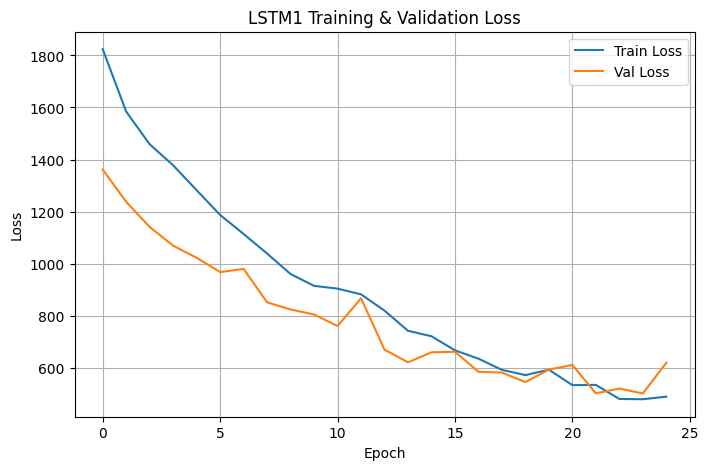

In [33]:
plt.figure(figsize=(8,5))

plt.plot(lstm1_history["train_loss"], label="Train Loss")
plt.plot(lstm1_history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM1 Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

**ANALYSIS:** The above plot shows that our training doesn't really improve performance past around epoch 18. The monotone decrease in both training and validation loss is exactly what we want to see, though. It is a much better plot than the first two. Let's see how much better the model does once we introduce gradient clipping and dropout.

#MODEL 4 - OPTIMIZED LSTM

In [35]:
# TRAIN AND EVALUATE USING LSTM MODEL - now with grad clipping and dropout
X_train, y_train, X_val, y_val, embed_dim = prepare_inputs(
    "lstm",
    train_set,
    val_set,
    encoder
)

lstm_model_2 = initialize_model("lstm", input_dim=embed_dim, optimized=True)

lstm2_history = train(
    lstm_model_2,
    True,
    X_train, y_train,
    X_val, y_val,
    epochs=25,
    batch_size=32,
    lr=1e-3
)
print("\nEvaluating metrics for second LSTM model:")
compute_val_metrics(lstm_model_2)

Epoch 1/25 Train Loss: 1799.3106 | Val Loss: 1365.2606
Epoch 2/25 Train Loss: 1583.1779 | Val Loss: 1267.2435
Epoch 3/25 Train Loss: 1473.5505 | Val Loss: 1192.9101
Epoch 4/25 Train Loss: 1394.7289 | Val Loss: 1078.5405
Epoch 5/25 Train Loss: 1300.1770 | Val Loss: 1022.1427
Epoch 6/25 Train Loss: 1234.8253 | Val Loss: 942.4547
Epoch 7/25 Train Loss: 1139.5991 | Val Loss: 868.8199
Epoch 8/25 Train Loss: 1073.9198 | Val Loss: 836.8984
Epoch 9/25 Train Loss: 1011.5517 | Val Loss: 809.6606
Epoch 10/25 Train Loss: 979.0099 | Val Loss: 752.8521
Epoch 11/25 Train Loss: 918.1179 | Val Loss: 715.5198
Epoch 12/25 Train Loss: 868.5943 | Val Loss: 714.1124
Epoch 13/25 Train Loss: 828.4286 | Val Loss: 705.9567
Epoch 14/25 Train Loss: 811.5693 | Val Loss: 752.3605
Epoch 15/25 Train Loss: 765.2202 | Val Loss: 632.0651
Epoch 16/25 Train Loss: 746.3444 | Val Loss: 633.0498
Epoch 17/25 Train Loss: 708.3270 | Val Loss: 591.8257
Epoch 18/25 Train Loss: 676.1571 | Val Loss: 611.3206
Epoch 19/25 Train Loss:

These metrics are disappointing, and show that there is definitely some further improvement that could be done for the prediction. By introducing both gradient clipping and dropout, we we were only able to decrease the RMSE by 1.8 and the MAE by 1; however, a MAE of 7.7 is solid for this project and is significantly better than the RNN's MAE of ~20.  

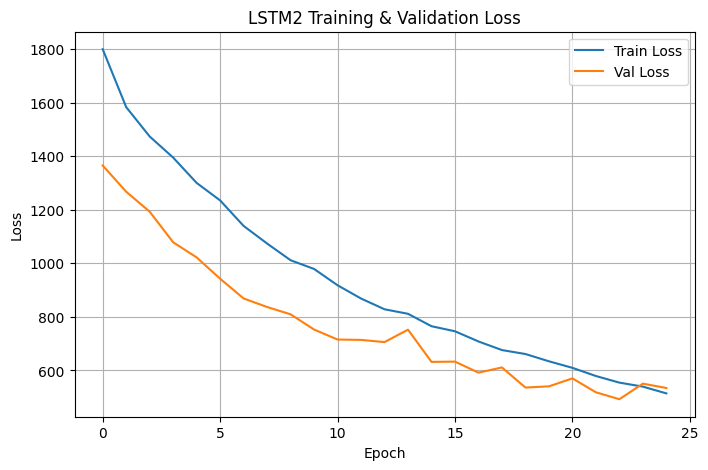

In [36]:
plt.figure(figsize=(8,5))

plt.plot(lstm2_history["train_loss"], label="Train Loss")
plt.plot(lstm2_history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM2 Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

**ANALYSIS:** This plot is very similar to that of the first LSTM model. Solid, monotone decreasing loss for both the training and validation loss, which is what we want to see.

#PREDICTING CARB CONTENT FOR UNSEEN DATA
###We will be using our optimized LSTM because it performed the best on our validation set.

In [37]:
# PREDICT UNSEEN DATA USING LSTM MODEL
X_test, embed_dim = prepare_test_inputs(
    "lstm",
    test_set,
    encoder
)

test_preds = []
batch_size = 32
lstm_model_2.eval()
with torch.no_grad():
    for i in range(0, X_test.size(0), batch_size):
        Xb = X_test[i:i+batch_size]
        preds = lstm_model_2(Xb)
        test_preds.append(preds.cpu())

test_preds = torch.cat(test_preds).numpy()

submission = test_set.copy()
submission["predicted_carb"] = test_preds
submission.to_csv('ECE180_final_preds.csv', index=False)

print(submission.head(5))



   Unnamed: 0                                              query  \
0       10000                               One cup of NFS beef.   
1       10001  A cracker-sized slice of American cheese and S...   
2       10002                1 fl oz of 53 proof coffee liqueur.   
3       10003          One cooked unit of braised lamb pancreas.   
4       10004            1 fluid ounce of Claret red table wine.   

   predicted_carb  
0        2.054958  
1        2.014369  
2        5.805940  
3        1.856156  
4        2.016534  
